In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from sklearn.ensemble import RandomForestClassifier

# Задача №2 - Собери пазл (2.0).

Даны кусочки изображения, ваша задача склеить пазл в исходную картинку. 

Условия:
* Дано исходное изображение для проверки, использовать собранное изображение в самом алгоритме нельзя;
* Картинки имеют друг с другом пересечение;
* После разрезки кусочки пазлов не были повернуты или отражены;
* НЕЛЬЗЯ выбрать опорную картинку для сбора пазла, как это было в homework 3
* В процессе проверки решения пазлы могут быть перемешаны, т.е. порядок пазлов в проверке может отличаться от исходного 

Изображения расположены по [ссылке](https://disk.yandex.ru/d/XtpawH1sV9UDlg).


# Алгоритм
1)	Поиск совпадений на картинках:
>a.	Ищем особые точки и их дескрипторы. `ф-ция spec_points2()`
<br/>b.	С помощью 'flann.knnMatch' ищем похожие особые точки на каждой паре картинок (все со всеми). `ф-ция puzzle()` 
2)	Собираем пазл `ф-ция draw_res()` :
>a.	У нас есть есть все пересечения, так что просто берет картинку и берем те, которые пересекаются с ней. 
<br/>b.	Чтобы найти какое пересечение, ищем по координатам особых точек, как нам предлагают совместить картинки, и берем то, что ближе всего к среднему.  
3) Рисуем и наслаждаемся
  

In [4]:
# вспомогательная функция
def plot_one_image(src_image, name='', is_gray=False):
    """
    Отрисовать с помощью plt изображение.
    
    :param src_image: np.ndarray: исходное изображение
    :param name: str: сточка, которая будет в названии (title)
    :param name: bool: флаг для отображения ЧБ изображений
    :param is_gray: : флаг для отображения ЧБ изображений
    :return: None
    """
    fig, m_axs = plt.subplots(1, 1, figsize=(16, 16), constrained_layout=False)
    ax1 = m_axs

    cmap = 'gray' if is_gray else None
    ax1.imshow(src_image, cmap=cmap)
    ax1.set_xticks([]), ax1.set_yticks([])
    if name:
        ax1.set_title(name)
    ax1.axis('off')
    plt.show()

In [5]:
def plot_images_grid(images, name=''):
    """
    Отрисовать сетку изображений.
    
    :param images: list из np.ndarray: изображения
    :param name: str: сточка, которая будет в названии (title)
    :return: None
    """
    
    if name == '':
        name = 'image'
    
    a = int(np.sqrt(len(images)))+1
    fig, axes = plt.subplots(len(images)//a+1, a, figsize=(16, 16))
    axes = axes.ravel()

    for i, im in enumerate(images):
        axes[i].imshow(im)
        axes[i].set_title(f'{name} {i}')

    for ax in axes:
        ax.axis('off')

Может можно было написать spec_points для обеих задач одну, но мне так было удобнее

In [6]:
def spec_points2(image):
    """
    Функция для поиска особых точек и получения их дескрипторов 
    """
    
    im = image.copy()
    hyp_params = dict(
        nfeatures = 150,
        nOctaveLayers = 8,
        contrastThreshold = 0.01,
        edgeThreshold = 10,
        sigma = 4.0)  # hyp params
    
#     detector = cv2.xfeatures2d.SIFT_create(**hyp_params)
    detector = cv2.SIFT_create(**hyp_params)

    keypoints, desc = detector.detectAndCompute(im, None)
    try:
        return keypoints, desc.astype(np.float32)
    except:
        return None, None

In [7]:
def pos_i_piece(pos_pieces, i):
    """
    Вспомогательная функция для draw_res() для поиска позиции для картинки i в списке pos_pieces
    """
    
    if not(i in [l[0] for l in pos_pieces]):
        return None
    
    return pos_pieces[([l[0] for l in pos_pieces]).index(i)][1]

In [8]:
def draw_res(pieces, keypoints, good_matches):
    """
    Функция сбора пазла 
    """
    
    hsv_pieces = [cv2.cvtColor(piece, cv2.COLOR_RGB2HSV) for piece in pieces]
    
    pos_pieces = [(0, [0, 0])]
    num = 0
    while num < len(pos_pieces):     
        i = pos_pieces[num][0]
        for j, gd_matches in good_matches[i]:
            if pos_i_piece(pos_pieces, j) != None:
                continue
            if not len(gd_matches):
                continue
            
            dx = np.zeros([len(gd_matches), 1])
            dy = np.zeros([len(gd_matches), 1])
            for k, gd_matche in enumerate(gd_matches):
                x1, y1 = keypoints[i][gd_matche.queryIdx].pt
                x2, y2 = keypoints[j][gd_matche.trainIdx].pt
                
                dx[k] = x1 - x2
                dy[k] = y1 - y2
            
            av_dx = dx.mean()
            av_dy = dy.mean()
            
            ind_y = np.argmin(np.abs(dy-av_dy))
            ind_x = np.argmin(np.abs(dx-av_dx))

            y = int(np.round(dy[ind_y]))
            x = int(np.round(dx[ind_x]))

            
            x0, y0 = pos_i_piece(pos_pieces, i)
            x += x0
            y += y0

            pos_pieces.append((j, [x,y]))
        num += 1

    x_pieces = np.array([l[1][0] for l in pos_pieces])
    y_pieces = np.array([l[1][1] for l in pos_pieces])
    min_x = x_pieces.min()
    max_x = x_pieces.max()
    min_y = y_pieces.min()
    max_y = y_pieces.max()

    sh_piece_max_x = pieces[pos_pieces[np.argmax(x_pieces)][0]].shape
    sh_piece_max_y = pieces[pos_pieces[np.argmax(y_pieces)][0]].shape
    max_x += sh_piece_max_x[1]
    max_y += sh_piece_max_y[0]


    res_im = np.zeros([max_y-min_y, max_x-min_x, 3])
    for i, pos_piece in pos_pieces:
        h, w, _ = pieces[i].shape
        x = pos_piece[0]
        y = pos_piece[1]
        res_im[y - min_y : y - min_y + h, x - min_x : x - min_x + w] = pieces[i]
    res_im = res_im.astype(np.uint8)
    
    return res_im

In [9]:
def puzzle(pieces):
    """
    Основная функция  
    """
    
    ratio_thresh = 0.40
    thresh_count = 3
    
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    descs = []
    keypoints = []
    for im in pieces:
        ki, di = spec_points2(im)
        descs.append(di)
        keypoints.append(ki)
        
    inds_res = []
    good_matches = []
    for i in range(len(descs)):
        good_matches.append([])
        for j in range(len(descs)):
            good_matches[-1].append([j, []])
            desc1 = descs[i]
            desc2 = descs[j]
            
            matches = flann.knnMatch(desc1, desc2, k=2)
            for m, n in matches:
                if m.distance < ratio_thresh * n.distance:
                    good_matches[-1][-1][1].append(m)
                    
            if len(good_matches[-1][-1][1]) < thresh_count:
                good_matches[-1].pop()
                
    return draw_res(pieces, keypoints, good_matches)
    

In [10]:
def get_puzzle(name_puzzle):
    """
    Функция достающая картинки пазла
    """
    
    path = "./puzzle/"+name_puzzle+'/'
    names = os.listdir(path)
    puzzle = []
    for path_im in os.listdir(path):
        puzzle.append(cv2.imread(path+'/'+path_im))
        puzzle[-1] = cv2.cvtColor(puzzle[-1], cv2.COLOR_BGR2RGB)
    return puzzle

In [11]:
pieces = get_puzzle('su_fighter_shuffle')
real_image = cv2.imread("./puzzle/su_fighter.jpg")
real_image = cv2.cvtColor(real_image, cv2.COLOR_BGR2RGB)

In [19]:
# plot_images_grid(pieces, 'piece')

In [22]:
# plot_one_image(real_image, 'Исходная картинка')

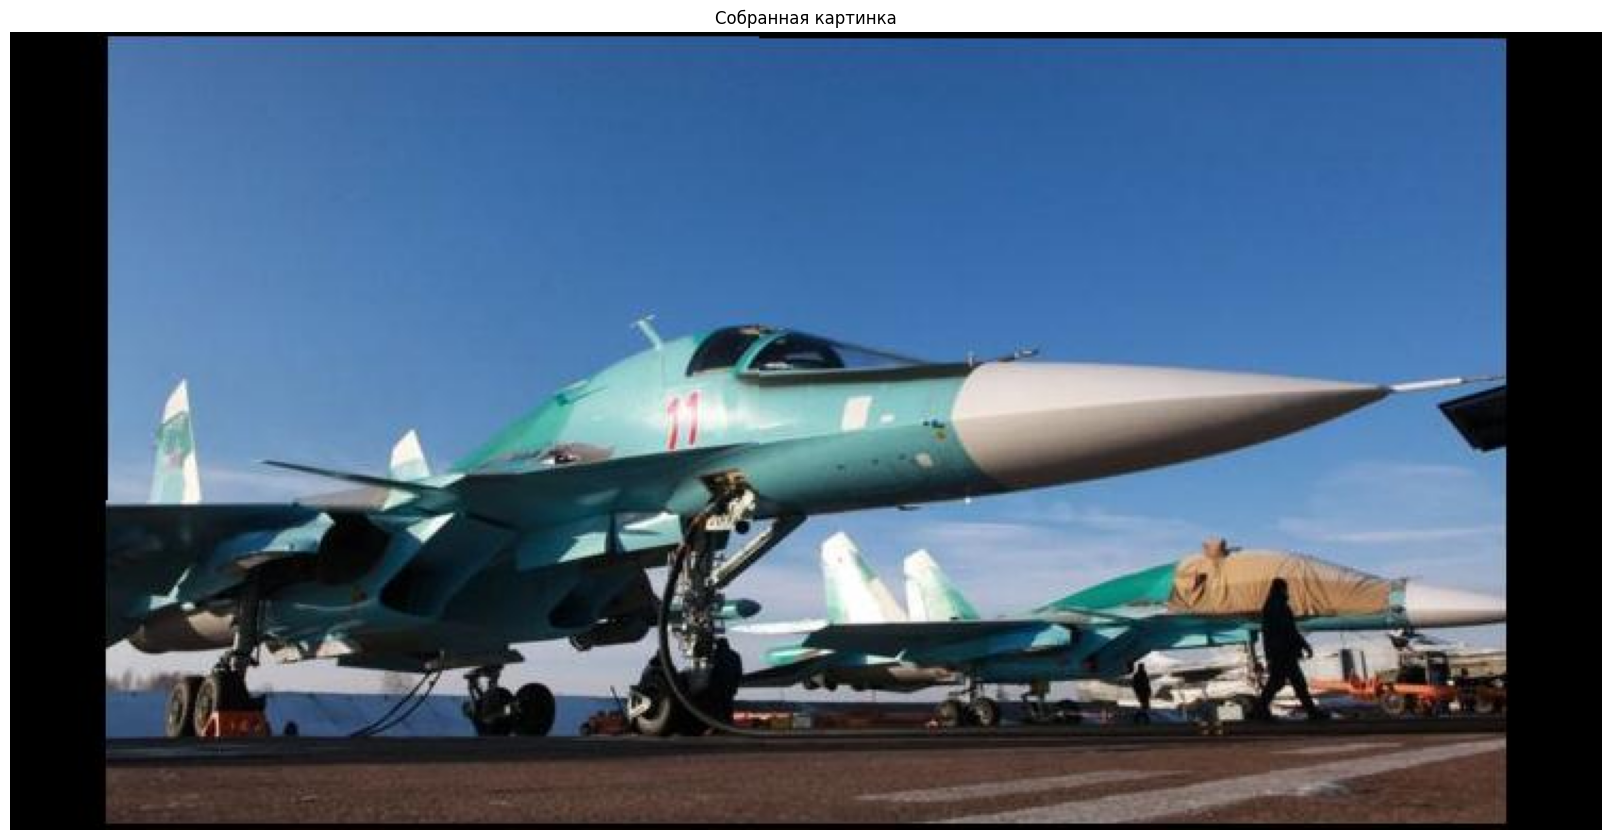

In [14]:
random.shuffle(pieces)
res_im = puzzle(pieces)
plot_one_image(res_im, 'Собранная картинка')

In [15]:
pieces = get_puzzle('china_shuffle')
real_image = cv2.imread("./puzzle/china.jpg")
real_image = cv2.cvtColor(real_image, cv2.COLOR_BGR2RGB)

In [20]:
# plot_images_grid(pieces, 'piece')

In [21]:
# plot_one_image(real_image, 'Исходная картинка')

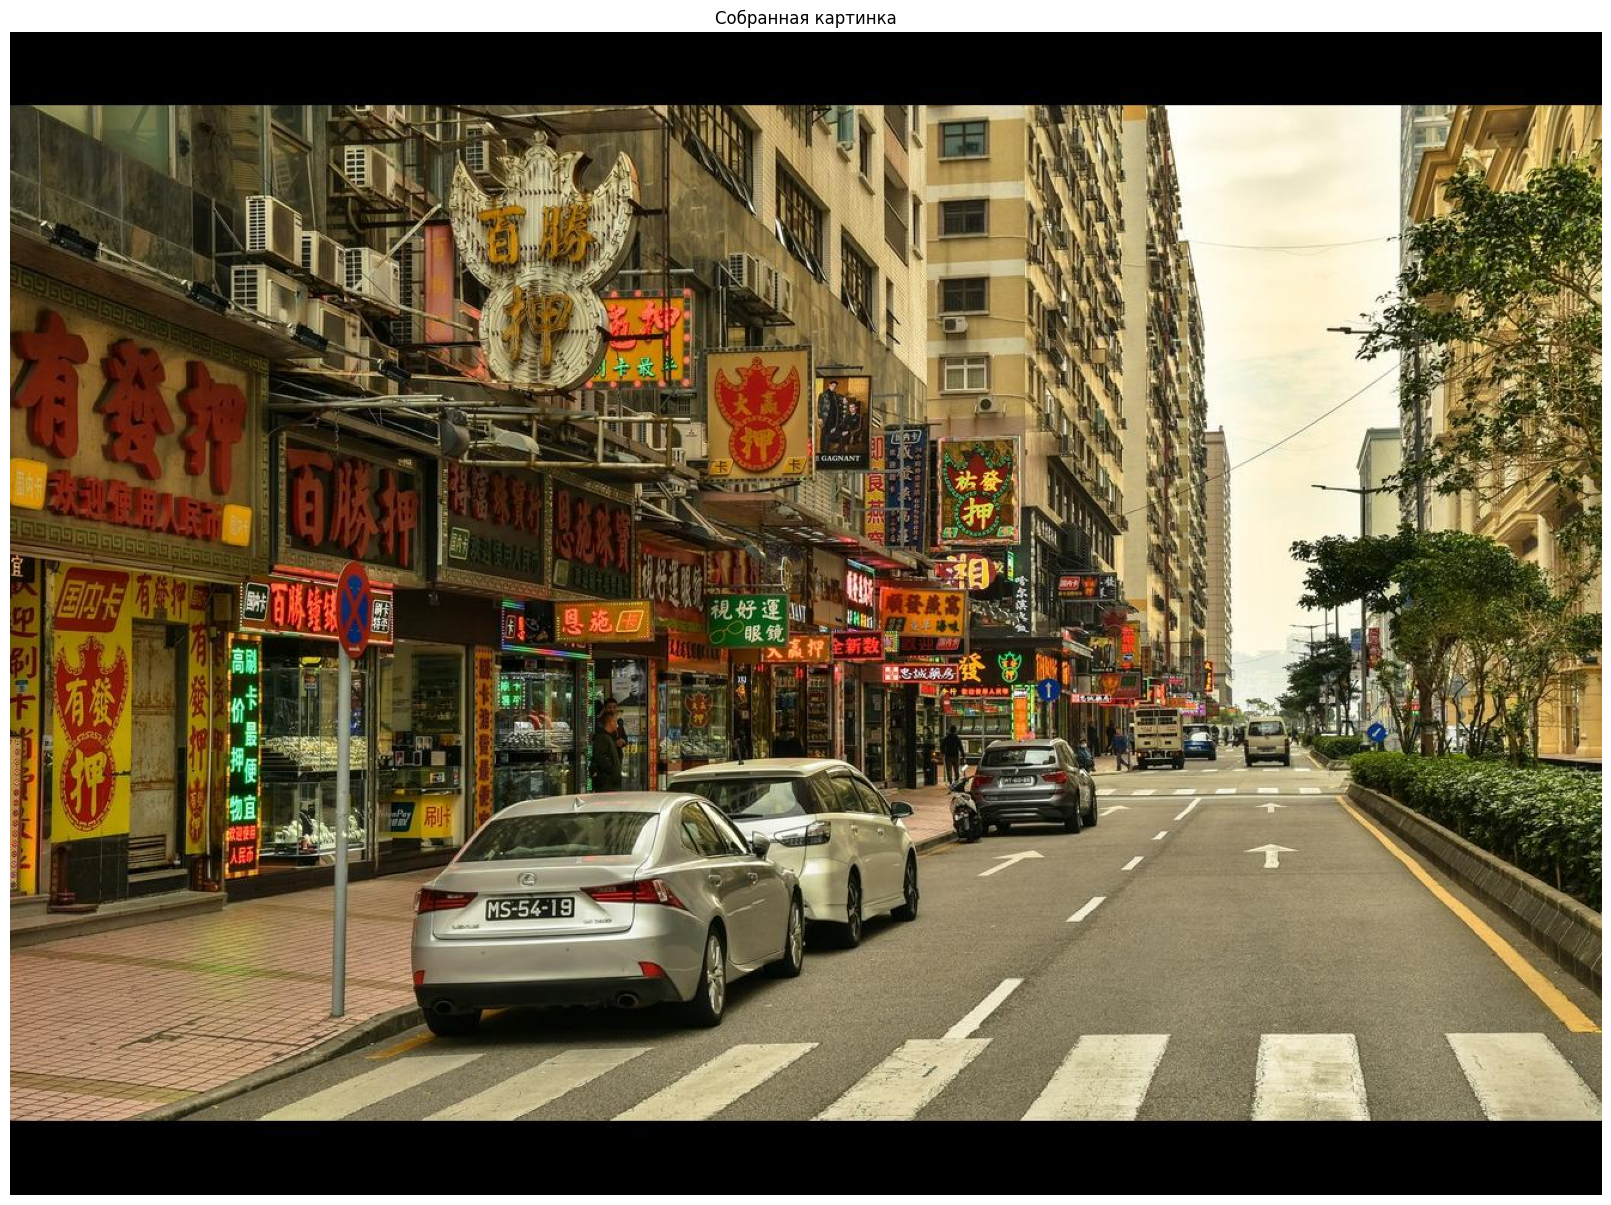

In [18]:
random.shuffle(pieces)
res_im = puzzle(pieces)
plot_one_image(res_im, 'Собранная картинка')

### Дом ~~я проклял~~  не получилось сделать 